<a href="https://colab.research.google.com/github/beccalunch/adv-ml-playground/blob/main/crucible/bear/bear_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
CRUCIBLE_API_KEY = ""  # Replace with your actual API key

In [4]:
import requests


artifacts = ["brown_bear.png", "ping_pong.png"]

for artifact in artifacts:
    url = f"https://crucible.dreadnode.io/api/artifacts/bear3/{artifact}"
    headers={"Authorization": "hzVUEuc8pfP78HQaWJcItf7iYahhK9O3"}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        with open(artifact, "wb") as file:
            file.write(response.content)
        print(f"{artifact} was successfully downloaded")
    else:
        print(f"Failed to download {artifact}")

brown_bear.png was successfully downloaded
ping_pong.png was successfully downloaded


In [5]:
import base64

with open('brown_bear.png', 'rb') as f:
    image = base64.b64encode(f.read()).decode()

In [6]:
def query(input_data):
    response = requests.post(
        "https://bear3.crucible.dreadnode.io/score",
        headers={"Authorization": "hzVUEuc8pfP78HQaWJcItf7iYahhK9O3"},
        json={"data": input_data}
    )
    return response.json()

query(image)

{'brown bear': 0.9997809529304504}

In [7]:
with open('ping_pong.png', 'rb') as f:
    image = base64.b64encode(f.read()).decode()

In [9]:
query(image)

{'brown bear': 2.3639397568331333e-06}

When we rotate the brown bear image, does it still think it is a brown bear?

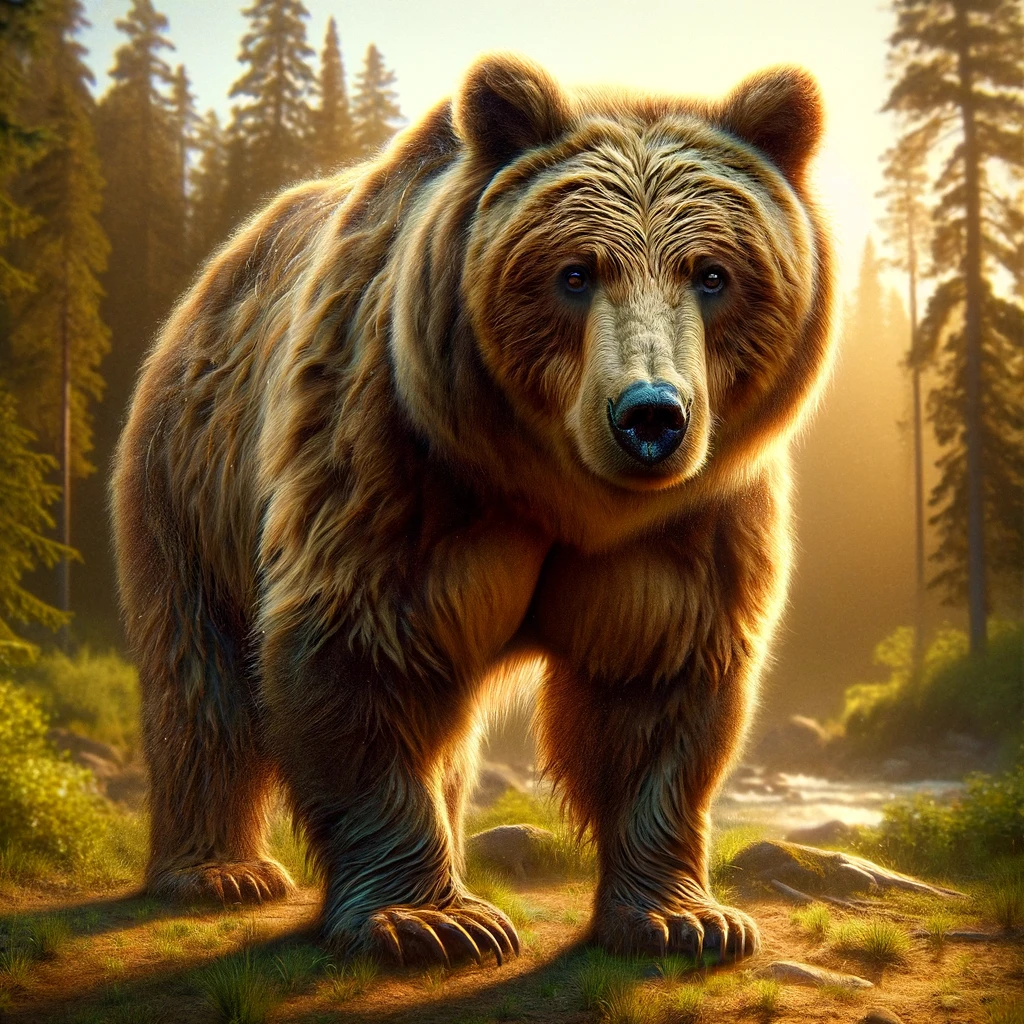

In [11]:
from PIL import Image
img = Image.open('brown_bear.png')
img

In [18]:
res = {}

for i in [0, 90, 180, 270, 360]:
  print(f"rotating image {i} degrees")
  rotated = img.rotate(i)
  # save rotated image
  path = f'img_rotated_{i}.png'
  rotated.save(path)

  with open(path, 'rb') as f:
    image = base64.b64encode(f.read()).decode()

  res[i] = query(image)


rotating image 0 degrees
rotating image 90 degrees
rotating image 180 degrees
rotating image 270 degrees
rotating image 360 degrees


In [19]:
res

{0: {'brown bear': 0.9997809529304504},
 90: {'brown bear': 0.0008641002932563424},
 180: {'brown bear': 0.0007431101985275745},
 270: {'brown bear': 0.0010278685949742794},
 360: {'brown bear': 0.9997809529304504}}

0 and 360 degrees are equal, the rest are very low. So it does not handle rotation well at all. This makes me think it could be a CNN classifier.

So the model only returns the probability for brown bear.

Ideas
- Pull in some common image classification models from Keras
- Train on common image datasets (imagenet, etc)
- Observe probabilities, find match
- Profit

In [20]:
# what models can we use?
import tensorflow as tf

dir(tf.keras.applications)

['ConvNeXtBase',
 'ConvNeXtLarge',
 'ConvNeXtSmall',
 'ConvNeXtTiny',
 'ConvNeXtXLarge',
 'DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB2',
 'EfficientNetB3',
 'EfficientNetB4',
 'EfficientNetB5',
 'EfficientNetB6',
 'EfficientNetB7',
 'EfficientNetV2B0',
 'EfficientNetV2B1',
 'EfficientNetV2B2',
 'EfficientNetV2B3',
 'EfficientNetV2L',
 'EfficientNetV2M',
 'EfficientNetV2S',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'MobileNetV3Large',
 'MobileNetV3Small',
 'NASNetLarge',
 'NASNetMobile',
 'RegNetX002',
 'RegNetX004',
 'RegNetX006',
 'RegNetX008',
 'RegNetX016',
 'RegNetX032',
 'RegNetX040',
 'RegNetX064',
 'RegNetX080',
 'RegNetX120',
 'RegNetX160',
 'RegNetX320',
 'RegNetY002',
 'RegNetY004',
 'RegNetY006',
 'RegNetY008',
 'RegNetY016',
 'RegNetY032',
 'RegNetY040',
 'RegNetY064',
 'RegNetY080',
 'RegNetY120',
 'RegNetY160',
 'RegNetY320',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'Re

In [38]:
# Let's start with MobileNetV2
pretrained_model = tf.keras.applications.InceptionV3(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

# function to preprocess the image for MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# extract labels from the probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]




96112376/96112376 [==============================] - 3s 0us/step


In [31]:
# Predicting on MobileNetV2
img_raw = tf.io.read_file('brown_bear.png')
image = tf.image.decode_image(img_raw)
image = preprocess(image)
image_probs = pretrained_model.predict(image)

1/1 [==============================] - 0s 120ms/step


35363/35363 [==============================] - 0s 0us/step


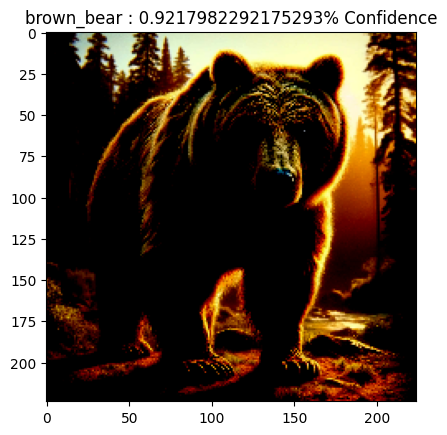

In [32]:
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title(f'{image_class} : {class_confidence}% Confidence')
plt.show()

Probability is much lower than our model... so let's try some others

We suspected it was a CNN because it could handle rotation, so what are some CNNs to try...
- convnext
- inception_v3
- ResNet
- VGG

In [43]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [49]:
import torch
import timm
from PIL import Image
from torchvision import transforms


# Function to load an image and transform it for model inference
def load_and_transform_image(image_path, rotation=None):
    transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    image = Image.open(image_path).convert("RGB")
    if rotation is not None:
      image = image.rotate(rotation)
    return transform(image).unsqueeze(0)  # Add batch dimension


# Function to perform prediction using a specified model
def predict_image(model_name, image_tensor):
    model = timm.create_model(model_name, pretrained=True)
    model.eval()
    with torch.no_grad():
        logits = model(image_tensor)
    return logits.argmax(dim=1), logits

In [48]:
[m for m in dir(timm.models) if 'vgg' in m.lower()]

['VGG',
 'repvgg_a0',
 'repvgg_a1',
 'repvgg_a2',
 'repvgg_b0',
 'repvgg_b1',
 'repvgg_b1g4',
 'repvgg_b2',
 'repvgg_b2g4',
 'repvgg_b3',
 'repvgg_b3g4',
 'repvgg_d2se',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn']

In [55]:
models = [
 'mobilenetv3_large_100',
 'resnet101',
 'resnet101c',
 'resnet101d',
 'resnet101s',
 'resnet10t',
 'resnet14t',
 'resnet152',
 'resnet152c',
 'resnet152d',
 'resnet152s',
 'resnet18',
 'resnet18d',
 'resnet26',
 'vgg11',
 'vgg13',
 'vgg16',
 'vgg19',
 ]


BROWN_BEAR_INDEX = 294  # Index for brown bear in ImageNet

for model_name in models:
  image_tensor = load_and_transform_image("brown_bear.png")
  prediction, logits = predict_image(model_name, image_tensor)
  probs = torch.softmax(logits, dim=1)  # Convert logits to probabilities
  print(f"Prediction from {model_name}: {prediction}")
  print(f"Brown bear probability: {probs[0][BROWN_BEAR_INDEX]:.4f}")

  # Test rotations:
  res = {}
  for i in [90, 180, 270]:
    image_tensor = load_and_transform_image("brown_bear.png", rotation=i)
    prediction, logits = predict_image(model_name, image_tensor)
    probs = torch.softmax(logits, dim=1)  # Convert logits to probabilities
    res[i] = probs[0][BROWN_BEAR_INDEX]

  print(f"Rotation probabilities from {model_name}:\n{res}")

Prediction from mobilenetv3_large_100: tensor([294])
Brown bear probability: 0.9507
Rotation probabilities from mobilenetv3_large_100:
{90: tensor(0.0005), 180: tensor(0.0073), 270: tensor(0.0007)}
Prediction from resnet101: tensor([294])
Brown bear probability: 0.7537
Rotation probabilities from resnet101:
{90: tensor(0.0282), 180: tensor(0.0046), 270: tensor(0.0848)}
Prediction from resnet101c: tensor([294])
Brown bear probability: 0.8960
Rotation probabilities from resnet101c:
{90: tensor(0.0185), 180: tensor(0.0024), 270: tensor(0.0211)}
Prediction from resnet101d: tensor([294])
Brown bear probability: 0.9819
Rotation probabilities from resnet101d:
{90: tensor(0.2751), 180: tensor(0.0034), 270: tensor(0.0315)}
Prediction from resnet101s: tensor([294])
Brown bear probability: 0.9481
Rotation probabilities from resnet101s:
{90: tensor(0.0360), 180: tensor(0.0038), 270: tensor(0.0190)}
Prediction from resnet10t: tensor([294])
Brown bear probability: 0.9312
Rotation probabilities from 

model.safetensors:   0%|          | 0.00/531M [00:00<?, ?B/s]

Prediction from vgg11: tensor([294])
Brown bear probability: 0.9743
Rotation probabilities from vgg11:
{90: tensor(0.0005), 180: tensor(3.4836e-05), 270: tensor(0.0001)}


model.safetensors:   0%|          | 0.00/532M [00:00<?, ?B/s]

Prediction from vgg13: tensor([294])
Brown bear probability: 0.9877
Rotation probabilities from vgg13:
{90: tensor(0.0002), 180: tensor(7.8166e-05), 270: tensor(0.0003)}


model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

Prediction from vgg16: tensor([294])
Brown bear probability: 0.9958
Rotation probabilities from vgg16:
{90: tensor(0.0006), 180: tensor(0.0025), 270: tensor(0.0027)}


model.safetensors:   0%|          | 0.00/575M [00:00<?, ?B/s]

Prediction from vgg19: tensor([294])
Brown bear probability: 0.9517
Rotation probabilities from vgg19:
{90: tensor(0.0010), 180: tensor(1.9822e-05), 270: tensor(2.2996e-05)}


In [57]:
# resnet18 matches our 0.9998 probability for the initial prediction
# expected prob: {0: {'brown bear': 0.9997809529304504},
#  90: {'brown bear': 0.0008641002932563424},
#  180: {'brown bear': 0.0007431101985275745},
#  270: {'brown bear': 0.0010278685949742794},
#  360: {'brown bear': 0.9997809529304504}}

# ImageNet classes: https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
PING_PONG_INDEX = 722

# Rotation probabilities all match as well! resnet18 it is
image_tensor = load_and_transform_image("ping_pong.png")
prediction, logits = predict_image('resnet18', image_tensor)
probs = torch.softmax(logits, dim=1)  # Convert logits to probabilities
print(f"Prediction from {model_name}: {prediction}")
print(f"Ping pong probability: {probs[0][PING_PONG_INDEX]}")


Prediction from vgg19: tensor([722])
Ping pong probability: 0.6980140209197998


In [58]:
import base64

with open('ping_pong.png', 'rb') as f:
    image = base64.b64encode(f.read())

def get_flag(pingpong_prob):
    response = requests.post(
        "https://bear3.crucible.dreadnode.io/score",
        headers={"Authorization": "hzVUEuc8pfP78HQaWJcItf7iYahhK9O3"},
        json={"pingpong": pingpong_prob},
    )
    return response.json()

ping_pong_prob = 0.6980140209197998
get_flag(ping_pong_prob)

{'flag': 'gAAAAABmLTgW_jwGvy6j8oDlIZn0ekugViKUMXxdODd7Ixf09-RYe4PnYAl_tT3y1spY5vSPCW5nv75Z5wxzJyLaDRLAvdFSnojUQoFG7H6rjtl2GrrDsvtQb53zm2C_Q6Vs-aKfrJRaXG2iEPDKZSNxQRNeZ-nNTcZk9ybRc5OE5Dfp9GWCTqo='}

In [59]:
# Submitting the flag
import requests


url = "https://crucible.dreadnode.io/api/submit-flag"
headers={"Authorization": "hzVUEuc8pfP78HQaWJcItf7iYahhK9O3"}
payload = {
    "challenge": "bear3",
    "flag": "gAAAAABmLTgW_jwGvy6j8oDlIZn0ekugViKUMXxdODd7Ixf09-RYe4PnYAl_tT3y1spY5vSPCW5nv75Z5wxzJyLaDRLAvdFSnojUQoFG7H6rjtl2GrrDsvtQb53zm2C_Q6Vs-aKfrJRaXG2iEPDKZSNxQRNeZ-nNTcZk9ybRc5OE5Dfp9GWCTqo="
}
response = requests.post(url, headers=headers, json=payload)
if response.status_code == 200:
    if response.json().get("correct") is True:
        print("The flag was correct. Congrats!")
    else:
        print("The flag was incorrect. Keep trying!")
else:
    print("There was an error submitting your flag")
    print(response.text)

The flag was correct. Congrats!
